In [38]:
import yfinance as yf
import pandas as pd
import os

In [65]:
sp500 = yf.Ticker("AAPL")
sp500 = sp500.history(period="max")
sp500.to_csv("sp500.csv")

In [66]:
sp500.index = pd.to_datetime(sp500.index)

In [67]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099058,0.099488,0.099058,0.099058,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094321,0.094321,0.093890,0.093890,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087429,0.087429,0.086999,0.086999,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089152,0.089582,0.089152,0.089152,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091737,0.092167,0.091737,0.091737,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-18 00:00:00-04:00,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
2024-06-20 00:00:00-04:00,213.929993,214.240005,208.850006,209.679993,86172500,0.0,0.0
2024-06-21 00:00:00-04:00,210.389999,211.889999,207.110001,207.490005,246421400,0.0,0.0


<Axes: xlabel='Date'>

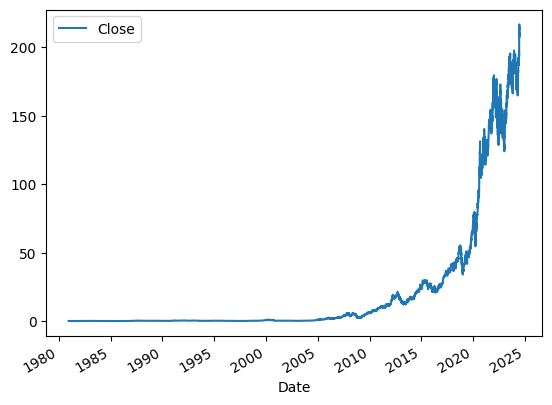

In [68]:
sp500.plot.line(y="Close", use_index=True)

In [69]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [70]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [71]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [73]:
sp500 = sp500.loc["1990-01-04":].copy()

In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [75]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5348837209302325

<Axes: xlabel='Date'>

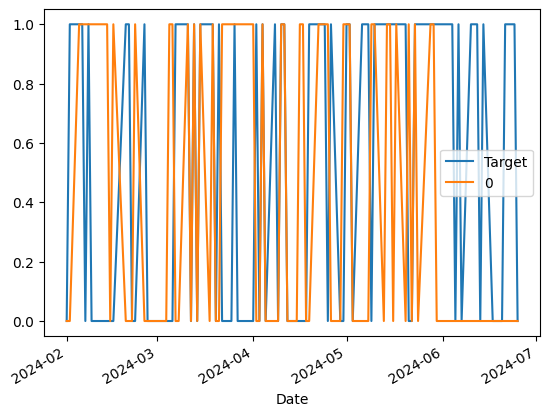

In [76]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [77]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [78]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [79]:
predictions = backtest(sp500, model, predictors)

In [80]:
predictions["Predictions"].value_counts()

Predictions
0    4116
1    2068
Name: count, dtype: int64

In [81]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5183752417794971

In [82]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.521184
0    0.478816
Name: count, dtype: float64

In [83]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [84]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [85]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-16 00:00:00-05:00,0.217114,0.218954,0.213435,0.216194,126369600,0.217114,1,0.993658,1.0,1.005994,2.0,1.010468,22.0,0.704569,110.0,0.642898,461.0
1993-12-17 00:00:00-05:00,0.217114,0.218954,0.214355,0.217114,145152000,0.209754,0,1.002123,1.0,1.001698,3.0,1.011960,23.0,0.709636,110.0,0.645728,461.0
1993-12-20 00:00:00-05:00,0.215274,0.218954,0.207914,0.209754,189033600,0.202395,0,0.982758,1.0,0.974357,2.0,0.975652,22.0,0.687599,110.0,0.623946,460.0
1993-12-21 00:00:00-05:00,0.209754,0.211594,0.200555,0.202395,251126400,0.206075,1,0.982144,0.0,0.950736,2.0,0.939899,22.0,0.665451,110.0,0.602168,460.0
1993-12-22 00:00:00-05:00,0.200555,0.209754,0.198714,0.206075,181372800,0.200555,0,1.009008,1.0,0.979877,2.0,0.955170,23.0,0.679573,110.0,0.613202,461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18 00:00:00-04:00,217.589996,218.630005,213.000000,214.289993,79943300,209.679993,0,0.994477,1.0,1.000644,3.0,1.173773,36.0,1.171031,133.0,1.408165,522.0
2024-06-20 00:00:00-04:00,213.929993,214.240005,208.850006,209.679993,86172500,207.490005,0,0.989127,0.0,0.982227,2.0,1.144441,36.0,1.145246,132.0,1.376773,521.0
2024-06-21 00:00:00-04:00,210.389999,211.889999,207.110001,207.490005,246421400,208.139999,1,0.994750,0.0,0.978154,1.0,1.128586,36.0,1.132745,132.0,1.361335,520.0


In [86]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [87]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [88]:
predictions = backtest(sp500, model, new_predictors)

In [89]:
predictions["Predictions"].value_counts()

Predictions
0.0    4596
1.0     588
Name: count, dtype: int64

In [90]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5391156462585034

In [91]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.530285
0    0.469715
Name: count, dtype: float64

In [92]:
predictions

,Target,Predictions
Date,,
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,0,0.0
2003-11-21 00:00:00-05:00,1,0.0
2003-11-24 00:00:00-05:00,0,0.0
...,...,...
2024-06-18 00:00:00-04:00,0,0.0
2024-06-20 00:00:00-04:00,0,0.0
2024-06-21 00:00:00-04:00,1,0.0
